In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

batch_size = 128
num_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-4   # L2 regularization
hidden_units = [1024, 512, 256]  # MLP architecture


Using device: cuda


In [11]:


print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
print("Current GPU device:", torch.cuda.current_device())
print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA available: True
GPU count: 8
Current GPU device: 0
GPU name: NVIDIA A100-SXM4-80GB


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # [0,255] -> [0,1] and HWC -> CHW
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616))
])

full_train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

#split train into train + validation
train_size = int(0.9 * len(full_train_dataset))  # 45k
val_size = len(full_train_dataset) - train_size  # 5k
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = full_train_dataset.classes
print("Classes:", classes)


Train size: 45000, Val size: 5000, Test size: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:

class CIFAR10MLP(nn.Module):
    def __init__(self, input_dim=3*32*32, hidden_units=[1024, 512, 256], num_classes=10, dropout_p=0.5):
        super(CIFAR10MLP, self).__init__()

        layers = []
        prev_dim = input_dim

        for h in hidden_units:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            # layers.append(nn.Dropout(p=dropout_p))
            prev_dim = h

        layers.append(nn.Linear(prev_dim, num_classes))

        self.network = nn.Sequential(*layers)
        

    def forward(self, x):
        # x: [batch_size, 3, 32, 32]
        batch_size = x.size(0)
        x = x.view(batch_size, -1) # Flatten to [batch_size, 3072]
        out = self.network(x)   # [batch_size, num_classes]
        return out


model = CIFAR10MLP(hidden_units=hidden_units).to(device)
print(model)


CIFAR10MLP(
  (network): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay  # L2 regularization on weights
)


def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
best_model_state = None

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

    print(f"Epoch [{epoch}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% || "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# Load best model weights (early stopping style)
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with Val Acc = {best_val_acc:.2f}%")


Epoch [1/100] Train Loss: 1.6793 | Train Acc: 40.12% || Val Loss: 1.5549 | Val Acc: 45.30%
Epoch [2/100] Train Loss: 1.4712 | Train Acc: 48.06% || Val Loss: 1.4709 | Val Acc: 47.96%
Epoch [3/100] Train Loss: 1.3601 | Train Acc: 51.95% || Val Loss: 1.4290 | Val Acc: 49.52%
Epoch [4/100] Train Loss: 1.2837 | Train Acc: 54.53% || Val Loss: 1.4137 | Val Acc: 51.00%
Epoch [5/100] Train Loss: 1.2218 | Train Acc: 56.46% || Val Loss: 1.3783 | Val Acc: 51.40%
Epoch [6/100] Train Loss: 1.1623 | Train Acc: 58.50% || Val Loss: 1.3710 | Val Acc: 53.06%
Epoch [7/100] Train Loss: 1.1001 | Train Acc: 60.87% || Val Loss: 1.3936 | Val Acc: 51.72%
Epoch [8/100] Train Loss: 1.0421 | Train Acc: 62.65% || Val Loss: 1.4075 | Val Acc: 52.06%
Epoch [9/100] Train Loss: 0.9932 | Train Acc: 64.41% || Val Loss: 1.4256 | Val Acc: 53.26%
Epoch [10/100] Train Loss: 0.9429 | Train Acc: 66.37% || Val Loss: 1.4378 | Val Acc: 53.14%
Epoch [11/100] Train Loss: 0.8993 | Train Acc: 67.70% || Val Loss: 1.5142 | Val Acc: 51.0

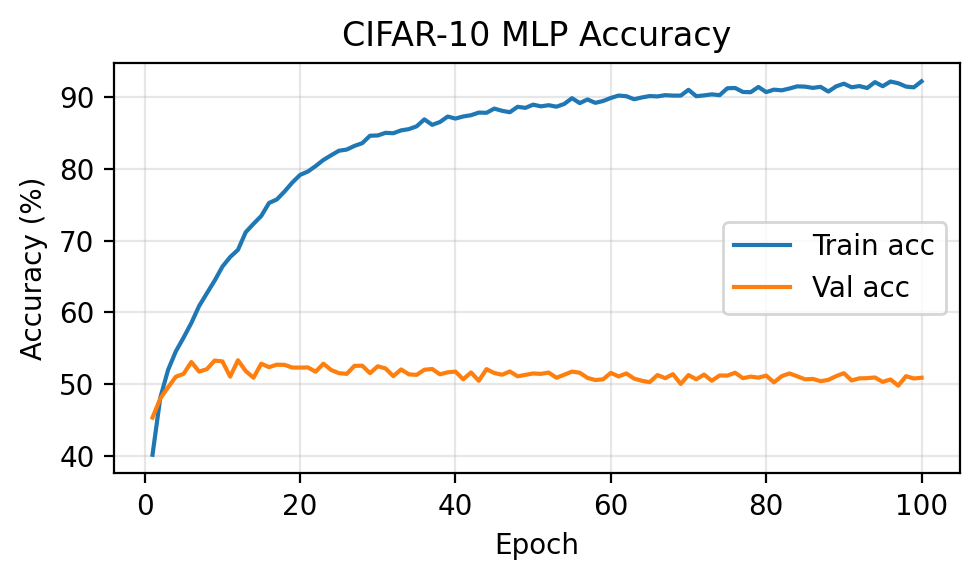

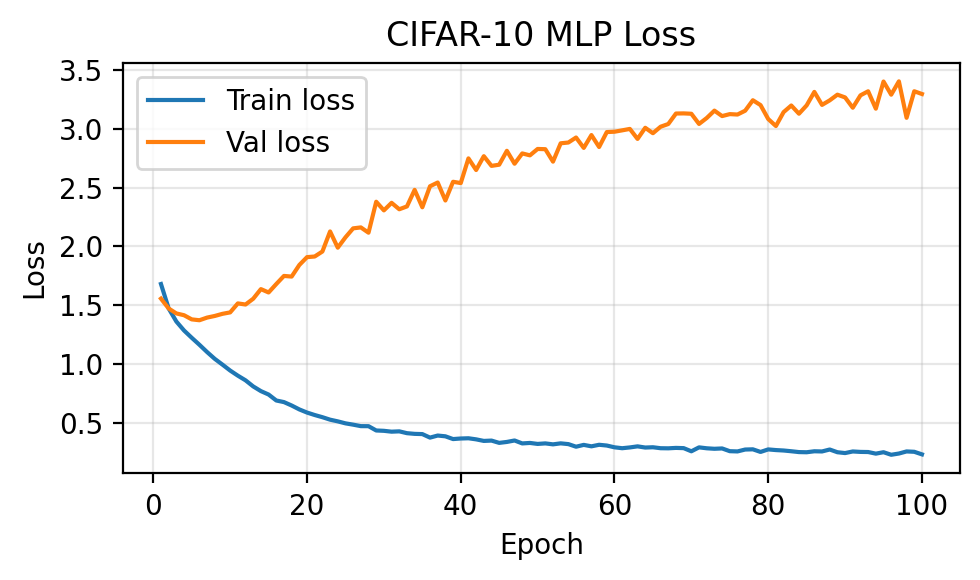

In [ ]:
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(5, 3), dpi=200)
plt.plot(epochs, train_accuracies, label="Train acc", linewidth=1.5)
plt.plot(epochs, val_accuracies, label="Val acc", linewidth=1.5)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("CIFAR-10 MLP Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3), dpi=200)
plt.plot(epochs, train_losses, label="Train loss", linewidth=1.5)
plt.plot(epochs, val_losses, label="Val loss", linewidth=1.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CIFAR-10 MLP Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")


Test Loss: 3.2736 | Test Accuracy: 52.24%
